# Low dimensional logistic regression label transfer of variance decomposed Single Cell Data

## Author Notes

* The following tutorial describes a method for integrating data by label transfering based on ridge regulariased logistic regression in low-dimensional space. This approach enables us to fit a model on the annotated training/landscape/reference dataset to predict labels of a new dataset and embed these labels onto neighbourhoods in the prediction data. 

* Logistic regression can (1) be used to classify samples, (2) use different types of data (continuous and descrete measurements)and (3) also be used to assess what variables are useful for classifying samples.

#### Current progress: 
- integrating a latent variable model for neighbourhood construction using factor decomposition. 
- Integration of BIC metric
- Integration of Robustness testing
#### Testing required: 
- Robustness of runs need to be tested by permutation of dependent variables and similairty of outcome tested using MI, RAND or BIC

# Author information

### Created on: 291020; Updated: 050621;
### Author: Issac Goh
### Proof readers/Testers: Simone Webb , Mariana Quiroga Londoño, Anthony Rose

In [1]:
import sys
import subprocess

#import pkg_resources
#required = {'harmonypy','sklearn','scanpy','pandas', 'numpy', 'bbknn', 'scipy', 'matplotlib', 'seaborn' ,'scipy'}
#installed = {pkg.key for pkg in pkg_resources.working_set}
#missing = required - installed
#if missing:
#    print("Installing missing packages:" )
#    print(missing)
#    python = sys.executable
#    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

%matplotlib inline
from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
from bbknn import bbknn
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
import harmonypy as hm
from pathlib import Path

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')

# Only block to edit in LR script

In [2]:
# Introduce variables
# Note that this script expects raw data to be in "non-batch-corrected" adata.raw.X. 

# Required: Introduce the path you'd like to save figures or data to 
save_path = "/Users/emilyjones/Desktop/HCA/project/script templates/raw counts/fix_lr_bm_mouse_V2"

# Required: Name of first object
data1 = "fbm"
# Provide path to obj1 // landscape/training data
Object1 = "/Users/emilyjones/Desktop/HCA/project/script templates/raw counts/FBM_raw_with_meta.h5ad" #This time loaded in processed 
# Provide categorical to join between datasets
cat1 = "cell.labels"

# Required: Name of second object
data2 = "mouse"
# Provide path to obj2 // prediction/projection data
Object2 = "/Users/emilyjones/Desktop/HCA/project/script templates/mouse/mouse_exp1_exp2_concat.h5ad"  #Make sure that this is unprocessed
# Provide categorical to join between datasets
cat2 = "batch_id"

# Required: LR Model Options
penalty='elasticnet' # can be ["l1","l2","elasticnet"]
sparcity=0.2
max_iter = 200 #Increase if experiencing max iter issues
l1_ratio = 0.5 #If using elasticnet, tis controls the ratio between l1 and l2

# Optional: Batch correction options (this is for correction of eventual combined dataset for data1 and data2)
# If you do not have a batch variable for either data1 or data2, please add a "filler" column in the relevent adata.obs
# for the purposes of batch_correction and batch args below.
# e.g., adata.obs["whatever"] = "something"; batch="whatever"
batch_correction = "Harmony" # Will accept Harmony, BBKNN or False as options
batch = ["orig.ident","batch_id",] # Previously both set to species batch, Will accept any batch categorical. Comma space a batch categorical for each dataset. Position 1 is for data1, position 2 is for data2

# Optional: miscellaneous Options.   
subsample_train = False # Samples the training data to the smallest fraction (highly dependent on resolution of input celltype categorical). This corrects for proportional differences between celltype labels of interest in the training data. E.g., training data has 50,000 B cells, 20,000 T cells and 100 HSCs. This function will subsample all training to 100 cells per cell type. 
subsample_prop = 0.2 # Give this option a proprtion to subsample to(e.g 0.2), if NA given, will subsample to smallest population
subsample_predict = False
subsample_prop_predict = 0.5
remove_non_high_var = True

train_x = 'X_pca' # Define the resource to train and predict on, PCA, X or UMAP (#if you wish to use gene expression, train_x = 'X')
remove_effect_of_custom_gene_list = 'NA' # "./cell_cycle_genes.csv" #remove a custom list of genes from just the variable genes to compute PCA from. Your .csv should have HGNC gene names in the first column to be read in as a vector, any column name is fine.
use_raw = True # Do you want to use adata.raw.X (recommended)

In [3]:
%%time
# Check if filepaths are good
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
if (Path(Object1).is_file() & Path(Object2).is_file()):
    print("adata file paths detetcted, proceeding to load")
    adata = sc.read(Object1)
    adata2 =  sc.read(Object2)
    del adata.uns
    del adata2.uns
else: 
    raise TypeError("one or more .h5ad paths cannot be accessed")

adata file paths detetcted, proceeding to load
CPU times: user 511 ms, sys: 487 ms, total: 999 ms
Wall time: 1.16 s


In [4]:
adata2.obs

,experiment_id,celltype,id,batch_id,lr_batch,batch
CCR1_R1_exp_2,exp_2,mono,CCR1_R1_mono,CCR1_exp_2,CCR1_exp_2,0
CCR1_R2_exp_2,exp_2,mono,CCR1_R2_mono,CCR1_exp_2,CCR1_exp_2,0
CCR1_R3_exp_2,exp_2,mono,CCR1_R3_mono,CCR1_exp_2,CCR1_exp_2,0
CCR1_R4_exp_2,exp_2,mono,CCR1_R4_mono,CCR1_exp_2,CCR1_exp_2,0
CCR2_R1_exp_2,exp_2,mono,CCR2_R1_mono,CCR2_exp_2,CCR2_exp_2,0
CCR2_R2_exp_2,exp_2,mono,CCR2_R2_mono,CCR2_exp_2,CCR2_exp_2,0
CCR2_R3_exp_2,exp_2,mono,CCR2_R3_mono,CCR2_exp_2,CCR2_exp_2,0
CCR2_R4_exp_2,exp_2,mono,CCR2_R4_mono,CCR2_exp_2,CCR2_exp_2,0
CCR1_R1_exp_1,exp_1,macropahge,CCR1_R1_macropahge,CCR1_exp_1,CCR1_exp_1,1
CCR1_R2_exp_1,exp_1,macropahge,CCR1_R2_macropahge,CCR1_exp_1,CCR1_exp_1,1


In [5]:
adata.obs["species_batch"] = 'human' +  adata.obs["fetal.ids"].astype(str)
adata2.obs["species_batch"] = 'mouse' + adata2.obs["batch_id"].astype(str)

In [6]:
#Move human genes into .var on mouse data
adata2.var = adata2.var.set_index('symbol')
adata2.var.index.names = ["index"]

# Below modules will be tuned into functions in package

## Combining data and Preprocess

In [7]:

# altering scanpy setting so that we can save it to our defined directory
sc._settings.ScanpyConfig(figdir=save_path)

# Combine and pre-process data to match correlations across PCA

# Module to detect shape mismatch and alternatively rebuild adata
if(use_raw==True):
    print('option detected to use raw data, proceeding to check if raw exists and if it matches data.X')
    if (hasattr(adata.raw, "X")):
        try: adata.X =  adata.raw.X  ; print('no mismatch in shape for adata detected')
        except: print("adata.X shape mismatched with adata.raw.X, proceeding to re-build data") ; adata = adata.raw.to_adata()
    else:
        print("no raw data detected in adata! proceeding to create raw partition from adata.X")
        adata.raw = adata
        
    if (hasattr(adata2.raw, "X")):
        try: adata2.X = adata2.raw.X ; print('no mismatch in shape for adata2 detected')
        except: print("adata2.X shape mismatched with adata.raw.X, proceeding to re-build data") ; adata2 = adata2.raw.to_adata()
    else:
        print("no raw data detected in adata! proceeding to create raw partition from adata.X")
        adata2.raw = adata2
            
# Define intersecting genes between datasets
adata_genes = list(adata.var.index)
adata2_genes = list(adata2.var.index)
keep_SC_genes = list(set(adata_genes) & set(adata2_genes))
print("keep gene list = " , len(keep_SC_genes), "adata1 gene length = ", len(adata_genes) , "adata2 gene length = ", len(adata2_genes) )

# Remove non-intersecting genes (this step will remove cite-seq data if training data is pure RNA seq)
adata_intersect1 = adata[:, keep_SC_genes]
adata = adata_intersect1
adata_intersect2 = adata2[:, keep_SC_genes]
adata2 = adata_intersect2

# Optional subsampling of training data to 
if(subsample_train == True):
    
    if not(subsample_prop=="NA"):
        print("option to subsample by proportion chosen")
        prop = subsample_prop
        grouped = data.groupby(cat1)
        df = grouped.apply(lambda x: x.sample(frac=prop))
        df = df.droplevel(cat1)
        keep = df.index
        adata = adata[adata.obs.index.isin(keep)]
    else:
        print("subsample by smallest population")
        data = adata.obs
        data = data.sample(frac=1).groupby(cat1).head(min(adata.obs.groupby(cat1).size()))
        keep = data.index
        adata = adata[adata.obs.index.isin(keep)]
        
# Optional subsampling of training data to 
if(subsample_predict == True):
    if not(subsample_prop_predict=="NA"):
        print("option to subsample by proportion chosen")
        prop = subsample_prop_predict
        data = adata2.obs[:]
        grouped = data.groupby(cat2)
        df = grouped.apply(lambda x: x.sample(frac=prop))
        df = df.droplevel(cat2)
        keep = df.index
        adata2 = adata2[adata2.obs.index.isin(keep)]
    else:
        print("subsample by smallest population")
        data = adata2.obs
        data = data.sample(frac=1).groupby(cat2).head(min(adata.obs.groupby(cat2).size()))
        keep = data.index
        adata2 = adata2[adata2.obs.index.isin(keep)]

# Create a common batch column and do simple sanity check for batch variables
if not((batch_correction == "False") and (len(batch)>1)):
    print("Batch correction option detected, proceeding to format batch variables")
    batch_var = "lr_batch"
    adata.obs["lr_batch"] = adata.obs[batch[0]]
    adata2.obs["lr_batch"] = adata2.obs[batch[1]]
else: raise TypeError("Batch correction option detected but requires at least one categorical for each dataset!")

# Create a common obs column in both datasets containing the data origin tag
common_cat = "corr_concat" 
adata.obs[common_cat] = adata.obs[cat1].astype(str) + data1
adata2.obs[common_cat] = adata2.obs[cat2].astype(str) + data2
adata.obs = adata.obs.astype('category')
adata2.obs = adata2.obs.astype('category')
concat = adata2.concatenate(adata, join='inner',index_unique=None, batch_categories=None)
adata = concat[:]
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.1, max_mean=4)
sc.pp.scale(adata, zero_center=False, max_value=None, copy=False) #zero_center=True (densifies output)

# Optionally remove genes of known confounding effect from variable list
if not (Path(remove_effect_of_custom_gene_list).is_file()):
    print("Custom gene list option is not selected or path is not readbale, proceeding with no variable removal")
else: 
    print("Custom gene removal list detected, proceeding to remove intersect from variable genes")
    regress_list = pd.read_csv(remove_effect_of_custom_gene_list)
    regress_list = regress_list.iloc[:, 0]
    adata.var["highly_variable"][adata.var.index.isin(regress_list)] = "False"

#Optionally remove genes that do not contribute to variance in combined data::Use only if training and predicting withsim reduced data    
if(remove_non_high_var==True):
    high_var = list(adata.var["highly_variable"][adata.var["highly_variable"]==True])
    adata = adata[:, adata.var["highly_variable"].isin(high_var)]   

# Now compute PCA
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')

# Batch correction options
# The script will test later which Harmony values we should use
if not(batch_correction == "False"):
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)    
if(batch_correction == "Harmony"):
    print("Commencing harmony")
    # Create hm subset
    adata_hm = adata[:]
    # Set harmony variables
    data_mat = np.array(adata_hm.obsm["X_pca"])
    meta_data = adata_hm.obs
    vars_use = [batch_var]
    # Run Harmony
    ho = hm.run_harmony(data_mat, meta_data, vars_use)
    res = (pd.DataFrame(ho.Z_corr)).T
    res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
    # Insert coordinates back into object
    adata_hm.obsm["X_pca_back"]= adata_hm.obsm["X_pca"][:]
    adata_hm.obsm["X_pca"] = np.array(res)
    # Run neighbours
    sc.pp.neighbors(adata_hm, n_neighbors=15, n_pcs=50)
    adata = adata_hm[:]
    del adata_hm
elif(batch_correction == "BBKNN"):
    print("Commencing BBKNN")
    sc.external.pp.bbknn(adata, batch_key=batch_var, approx=True, metric='angular', copy=False, n_pcs=50, trim=None, n_trees=10, use_faiss=True, set_op_mix_ratio=1.0, local_connectivity=15) 
    
print("adata1 and adata2 are now combined and preprocessed in 'adata' obj - success!")

option detected to use raw data, proceeding to check if raw exists and if it matches data.X
no mismatch in shape for adata detected
no raw data detected in adata! proceeding to create raw partition from adata.X
keep gene list =  10531 adata1 gene length =  33712 adata2 gene length =  10957


Trying to set attribute `.obs` of view, copying.


Batch correction option detected, proceeding to format batch variables


Trying to set attribute `.obs` of view, copying.


normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Custom gene list option is not selected or path is not readbale, proceeding with no variable removal
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)
Commencing harmony


2021-09-01 09:35:18,577 - harmonypy - INFO - Iteration 1 of 10
2021-09-01 09:35:25,675 - harmonypy - INFO - Iteration 2 of 10
2021-09-01 09:35:32,461 - harmonypy - INFO - Iteration 3 of 10
2021-09-01 09:35:40,661 - harmonypy - INFO - Iteration 4 of 10
2021-09-01 09:35:48,410 - harmonypy - INFO - Converged after 4 iterations


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
adata1 and adata2 are now combined and preprocessed in 'adata' obj - success!


computing UMAP


Trying to set attribute `.uns` of view, copying.


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)


/Applications/anaconda3/envs/python_1.8.1/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'lr_batch' as categorical
/Applications/anaconda3/envs/python_1.8.1/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'species_batch' as categorical
/Applications/anaconda3/envs/python_1.8.1/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categorie

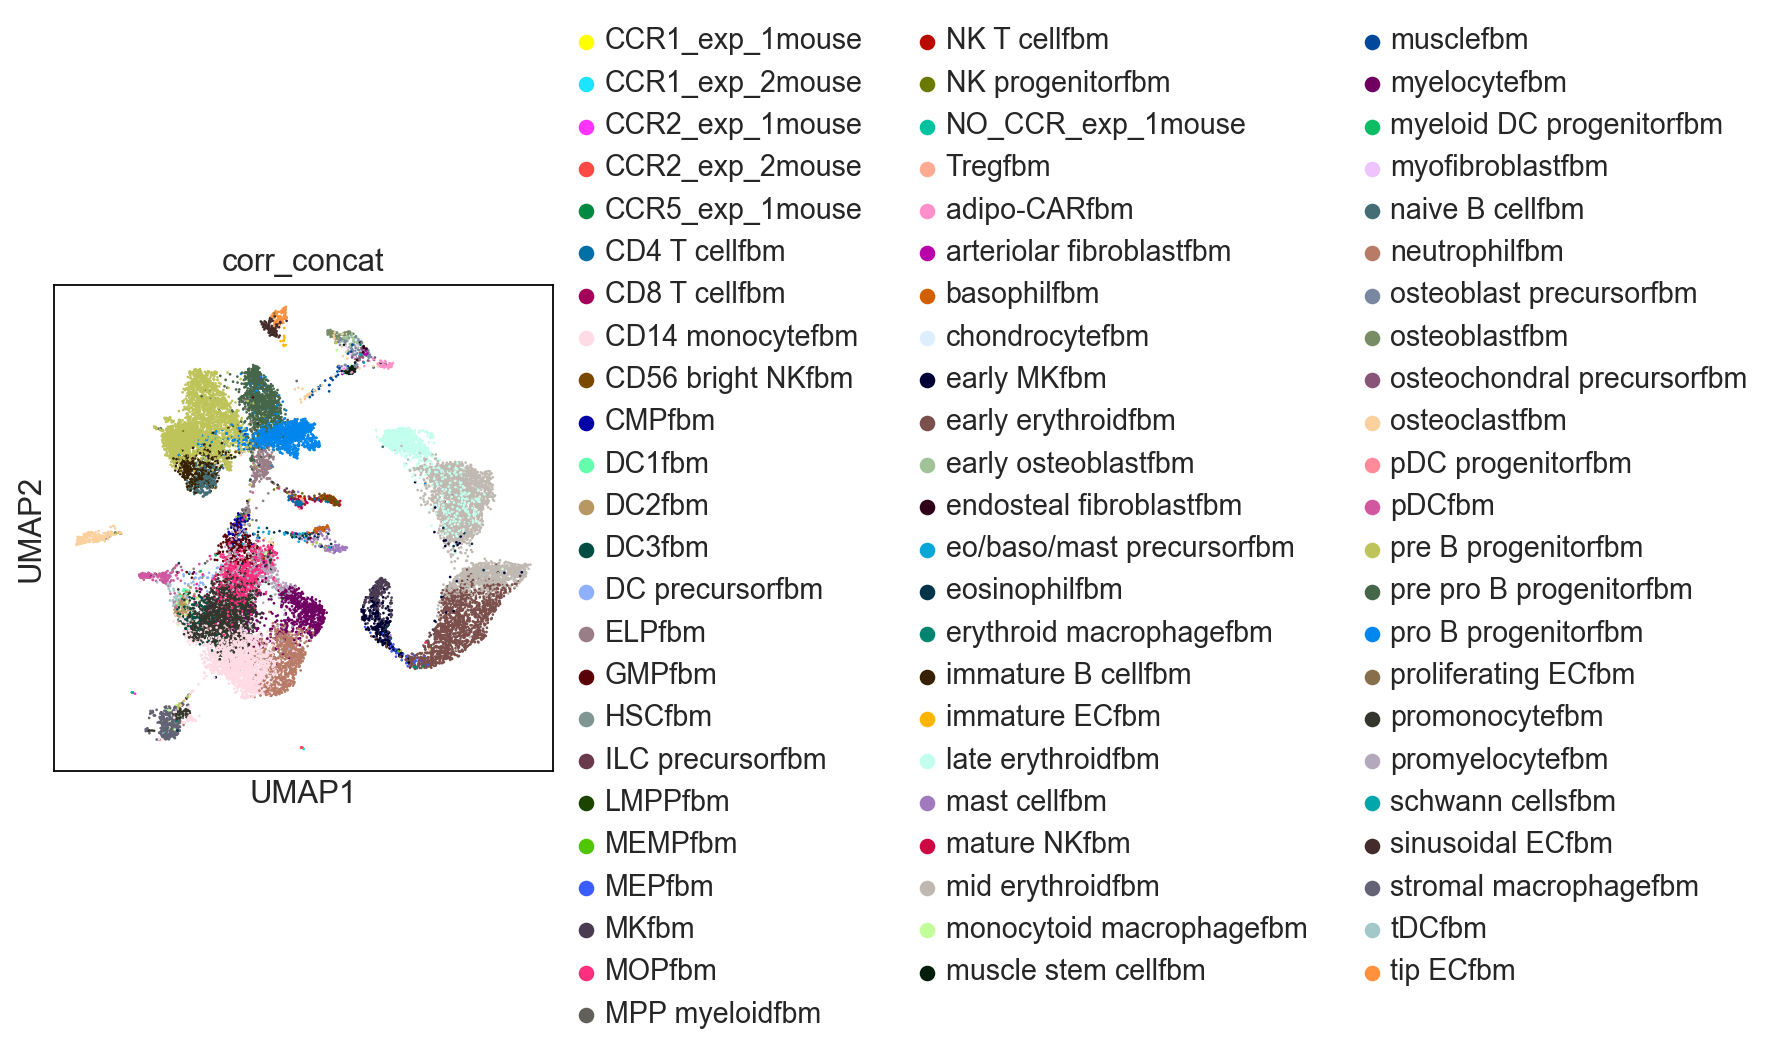

In [8]:
sc.tl.umap(adata)
sc.pl.umap(adata,color='corr_concat')

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


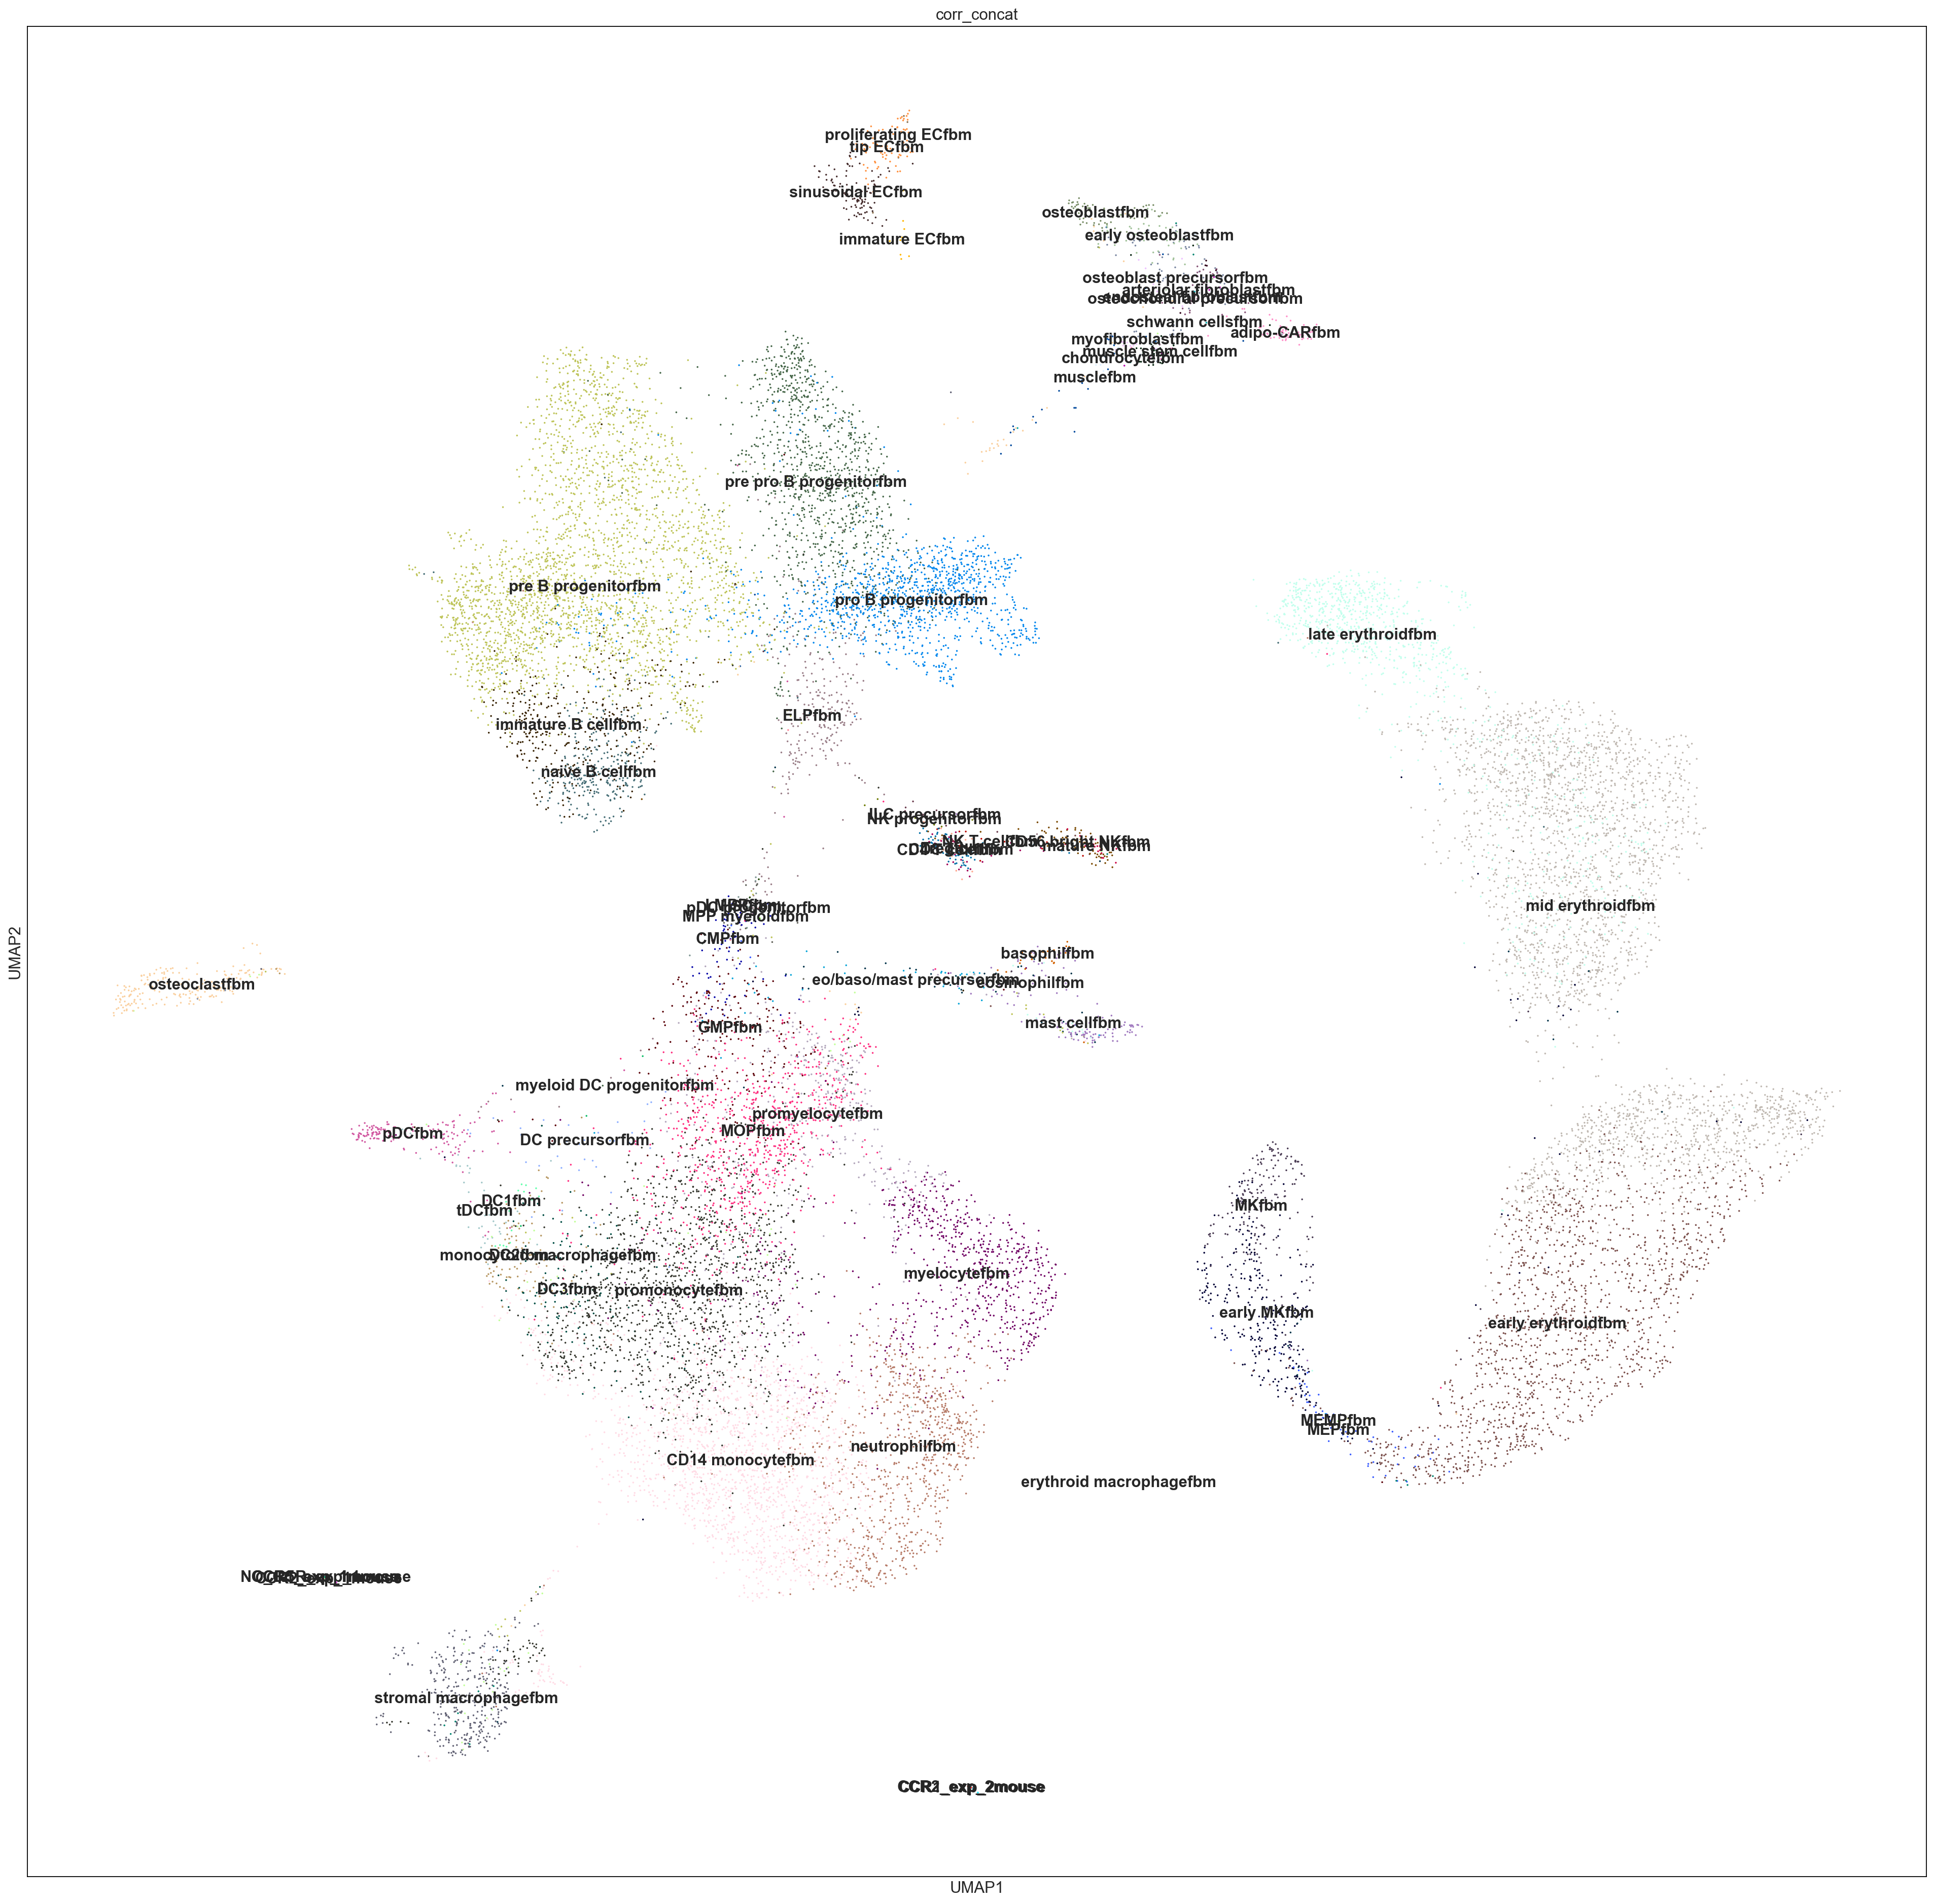

In [9]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
plt.rcParams["figure.figsize"] = (30,30)
sc.tl.umap(adata)
sc.pl.umap(adata,color=common_cat,size=10, legend_loc='on data')

## Logistic regression function to train data set and transfer labels

/Applications/anaconda3/envs/python_1.8.1/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/envs/python_1.8.1/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Text(264.0, 0.5, 'Predicted labels')

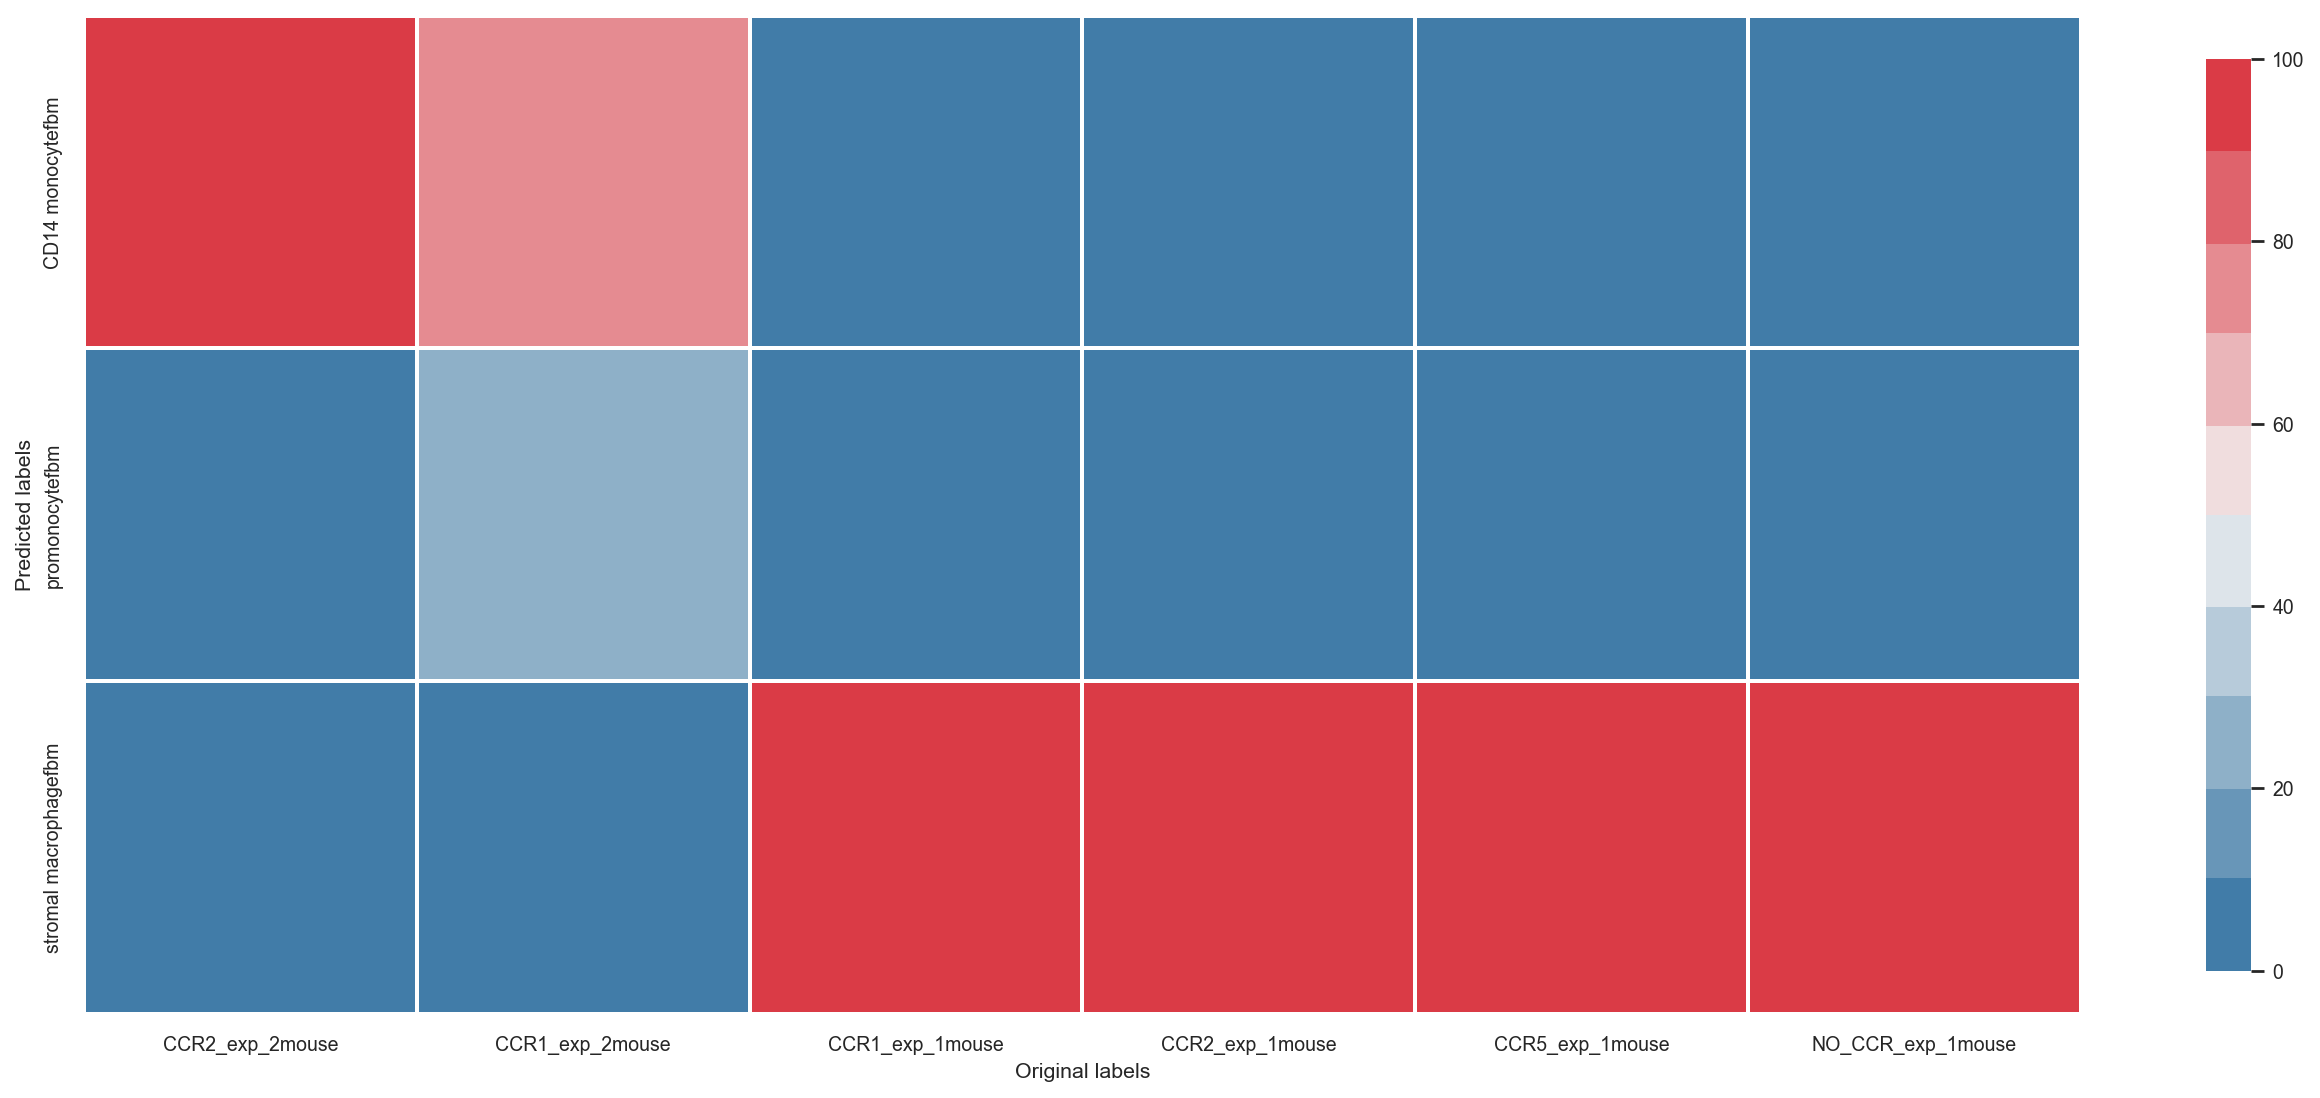

In [10]:
# This function require compute power, will take a while 

def LR_compare(adata, train_x, train_label, subset_predict, subset_train, penalty=penalty, sparcity=sparcity, 
               col_name='predicted'):

    # adata - training+prediction adata object (combined). Pre-processed already
    # sparsity - larger sparsity, more bins, more conservative predictions, less accurate. Low sparist for clean output
                # A value of 0.2 is reasonable for L2 ridge regression
    # penalty - acts as buffer for assigning bins too harshly
    # train_x - arg refers to where you would like to derive your training reference from, i.e., GEX (X) or/elif.
                # PCA/UMAP in obsm. The two 'if' statements below handle train_x differently based on this
                # Based on train_x, the loops below compute 'train_label' (cell type values in training/landscape data) 
                # and 'predict_x'(prediction data equivalent of train_x)
    # train_label - cell type values in training/landscape data
    # subset_predict - mandatory subset of predict_x which contains metadata for expression
    # subset_train - mandatory subset of train_x which contains metadata for expression
    
    # Redefine LR parameters 'penalty' and 'sparsity' if you would like to deviate from defaults set above
    
    # Assign 'lr' as sklearn logistic regression func, with penalty and sparsity defined above
    lr = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  max_iter)
    
    if (penalty == "l1"):
        lr = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  max_iter, dual = True, solver = 'liblinear')
    if (penalty == "elasticnet"):
        lr = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  max_iter, dual=False,solver = 'saga',l1_ratio=l1_ratio)

    if train_x == 'X':
        # Define training parameters
        train_label = adata.obs[common_cat].values
        train_label = train_label[subset_train]
        #train_x = adata.X,
        # Define prediction parameters
        #predict_x = train_x
        #train_x = train_x[subset_train, :] # issue line! subset_train = np.array(adata.obs[common_cat].isin(group1))
                                           # group1 = (adata.obs[common_cat][adata.obs[common_cat].str.contains(Data1_group)]).unique()
                                           # Data1_group = data1 = healthy skin data , adata containing subsetting data to get metadata for expression prediction
                                           # adata.X = adata.X[np.array(adata.obs[common_cat].isin(group1)), :]
                                           # train_x = train_x[adata.obs[common_cat].isin(group1)]
                        
        #predict_x = train_x
        #predict_x = predict_x[subset_predict]
        train_x = adata.X[adata.obs.index.isin(list(adata.obs[subset_train].index))]
        predict_x = adata.X[adata.obs.index.isin(list(adata.obs[subset_predict].index))]

    elif train_x in adata.obsm.keys():
        # Define training parameters
        train_label = adata.obs[common_cat].values
        train_label = train_label[subset_train]
        train_x = adata.obsm[train_x]
        predict_x = train_x
        train_x = train_x[subset_train, :]
        # Define prediction parameters
        predict_x = predict_x[subset_predict]
        predict_x = pd.DataFrame(predict_x)
        predict_x.index = adata.obs[subset_predict].index

    # Train predictive model using user defined partition labels (train_x ,train_label, predict_x)
    model = lr.fit(train_x, train_label)
    lr.fit(train_x, train_label)
    predict = lr.predict_proba(predict_x)

    # Create prediction table and map to adata.obs (in adata.obs["predict"] in the combined object), for the cells that
    # are in predict dataset
    predict = lr.predict(predict_x)
    predict = pd.DataFrame(predict)
    predict.index = adata.obs[subset_predict].index
    adata.obs[col_name] = adata.obs.index
    adata.obs[col_name] = adata.obs[col_name].map(predict[0])

# Function to plot heatmap by percentage
def plot_df_heatmap(df, cmap='viridis', title=None, figsize=(7, 7), rotation=90, save=None, **kwargs):
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(df, cmap=cmap, aspect='auto', **kwargs)
    if 0 < rotation < 90:
        horizontalalignment = 'right'
    else:
        horizontalalignment = 'center'
    plt.xticks(
        range(len(df.columns)),
        df.columns,
        rotation=rotation,
        horizontalalignment=horizontalalignment,
    )
    plt.yticks(range(len(df.index)), df.index)
    if title:
        fig.suptitle(title)
    #fig.colorbar(im)
    if save:
        plt.savefig(fname=save, bbox_inches='tight', pad_inches=0.1)

# Plot probability table by html
def cross_table(adata, x, y, normalise=None, highlight=False, subset=None):                                                                                                                                                                                              
    """Make a cross table comparing two categorical annotations
    """
    x_attr = adata.obs[x]
    y_attr = adata.obs[y]
    if subset is not None:
        x_attr = x_attr[subset]
        y_attr = y_attr[subset]
    crs_tbl = pd.crosstab(x_attr, y_attr)
    if normalise == 'x':
        x_sizes = x_attr.groupby(x_attr).size().values
        crs_tbl = (crs_tbl.T / x_sizes).round(2).T
    elif normalise == 'y':
        y_sizes = x_attr.groupby(y_attr).size().values
        crs_tbl = (crs_tbl / y_sizes).round(2)
    if highlight:
        return crs_tbl.style.background_gradient(cmap='viridis', axis=0)
    return crs_tbl

# Define the separator category in the column of interest, this works by partial matches and enables a-symmetric 
# comparisons
Data1_group = data1
Data2_group = data2
# Define the common .obs column between concatinated data
common_cat = "corr_concat"

# This block defines subset_predict and subset_train and also runs LR_compare function
group1 = (adata.obs[common_cat][adata.obs[common_cat].str.contains(Data1_group)]).unique()
group1 = list(group1)
group2 = (adata.obs[common_cat][adata.obs[common_cat].str.contains(Data2_group)]).unique()
group2 = list(group2)
subset_predict = np.array(adata.obs[common_cat].isin(group2))
subset_train = np.array(adata.obs[common_cat].isin(group1))
train_label = (adata.obs[common_cat][adata.obs[common_cat].isin(group1)]).values

LR_compare(adata, train_x, train_label, subset_predict, subset_train, sparcity=sparcity, col_name='predicted')

################################################################################################################################################################
#HTML cross-table construction

# Plotting purposes - Subset data to only contain prediction data with new predicted labelså
# Make adata the predicted data with projected annotations in adata.obs["predicted"]. "corr_concat" contains old 
# cell.labels and dataset name combined 
common_cat = "corr_concat"
adata_concat = adata[:]
adata = adata[adata.obs["predicted"].isin(group1)]
adata = adata[adata.obs["corr_concat"].isin(group2)]

# The results, are displayed in a python notebook or rendered as a html (just for quick visualisation, not saving)
# This table represents probability (binary cell type assignment) - numbers represent number of cells
# Columns contain number of original cells from adata2 that are now labelled using the training dataset, adata1
# (as shown on y axis)
crs_tbl = cross_table(adata, x = 'predicted', y = common_cat, highlight = True)
#crs_tbl

################################################################################################################################################################
# Heatmap function

x = 'predicted'
y = common_cat

y_attr = adata.obs[y]
x_attr = adata.obs[x]
crs = pd.crosstab(x_attr, y_attr)
crs_tbl = crs
for col in crs_tbl :
    crs_tbl[col] = crs_tbl[col].div(crs_tbl[col].sum(axis=0)).multiply(100).round(2)
# Sort df columns by rows
crs_tbl = crs_tbl.sort_values(by =list(crs_tbl.index), axis=1,ascending=False)
# Plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, vmin=20, vmax=70)
pal = sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(20,15))
sns.set(font_scale=0.8)
g = sns.heatmap(crs_tbl, cmap=pal, vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.5})
plt.xlabel("Original labels")
plt.ylabel("Predicted labels")
#plt.savefig(save_path + "/LR_predictions.pdf")
#crs_tbl.to_csv(save_path + "/pre-freq_LR_predictions_supp_table.csv")

### Proportion of cells per group

In [11]:
prop = adata.obs.groupby('predicted').count()
prop['percentage'] = (prop.iloc[:,6]/prop.iloc[:,6].sum())*100
prop = prop['percentage']
prop.to_csv(save_path + "/pre-freq_predicted_prop.csv")
prop

predicted
CD14 monocytefbm         35.0
promonocytefbm            5.0
stromal macrophagefbm    60.0
Name: percentage, dtype: float64

## Clustering 

In [12]:
# Optional clustering 
res = 5
key_add = 'leiden'
adata.obs[key_add] = "nan"
sc.tl.leiden(adata, resolution= res, key_added= key_add, random_state=26, n_iterations=-1)

Trying to set attribute `.obs` of view, copying.


running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [13]:
cluster_prediction = "clus_prediction"
clusters_reassign = "leiden"
lr_predicted_col = 'predicted'

In [14]:
adata.obs[cluster_prediction] = adata.obs.index
for z in adata.obs[clusters_reassign].unique():
    df = adata.obs
    df = df[(df[clusters_reassign].isin([z]))]
    df_count = pd.DataFrame(df[lr_predicted_col].value_counts())
    freq_arranged = df_count.index
    cat = freq_arranged[0]
    df.loc[:,cluster_prediction] = cat
    adata.obs.loc[adata.obs[clusters_reassign] == z, [cluster_prediction]] = cat

/Applications/anaconda3/envs/python_1.8.1/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


### Heatmap showing cells in predicted clusters

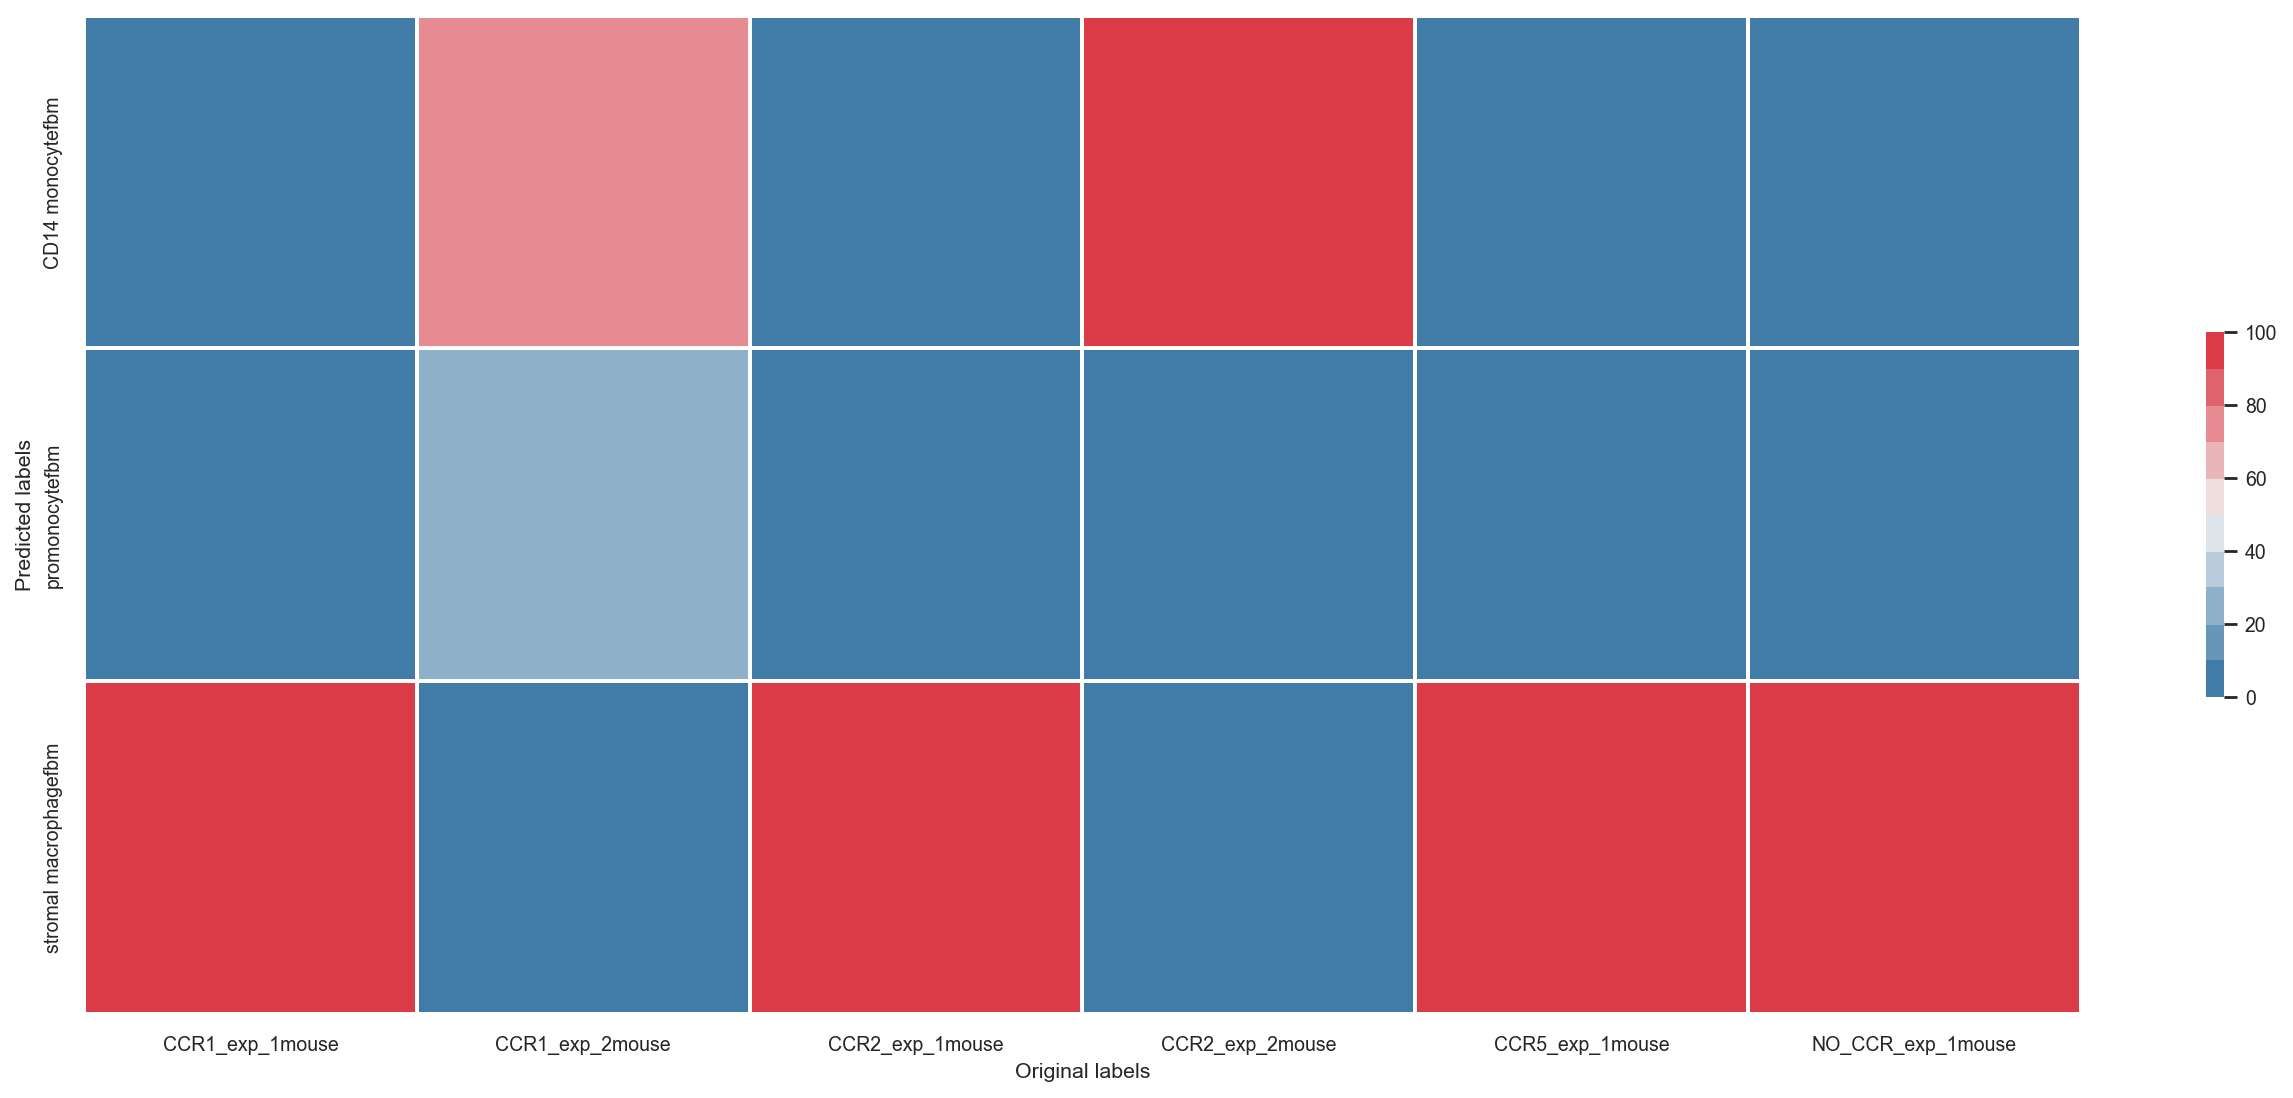

In [15]:
# Create a concat col for old + predicted annots
adata.obs['annot_clus_prediction_concat'] = adata.obs[cat1].astype(str) + "_" + adata.obs['clus_prediction'].astype(str)

x='clus_prediction'
y = common_cat

y_attr = adata.obs[y]
x_attr = adata.obs[x]
crs = pd.crosstab(x_attr, y_attr)
crs_tbl = crs
for col in crs_tbl :
    crs_tbl[col] = crs_tbl[col].div(crs_tbl[col].sum(axis=0)).multiply(100).round(2)

#plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, vmin=20, vmax=70)
pal = sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(20,10))
sns.set(font_scale=0.8)
g = sns.heatmap(crs_tbl, cmap=pal, vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.3})
plt.xlabel("Original labels")
plt.ylabel("Predicted labels")
plt.savefig(save_path + "/LR_predictions_consensus.pdf")
crs_tbl.to_csv(save_path + "/post-freq_LR_predictions_consensus_supp_table.csv")

In [16]:
prop = adata.obs.groupby('clus_prediction').count()
prop['percentage'] = prop.iloc[:,6]/prop.iloc[:,6].sum()
prop = prop['percentage']
prop.to_csv(save_path + "/post-freq_predicted_leiden_consensus_prop.csv")
prop

clus_prediction
CD14 monocytefbm         0.35
promonocytefbm           0.05
stromal macrophagefbm    0.60
Name: percentage, dtype: float64

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


/Applications/anaconda3/envs/python_1.8.1/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted' as categorical
/Applications/anaconda3/envs/python_1.8.1/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'clus_prediction' as categorical
/Applications/anaconda3/envs/python_1.8.1/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_catego

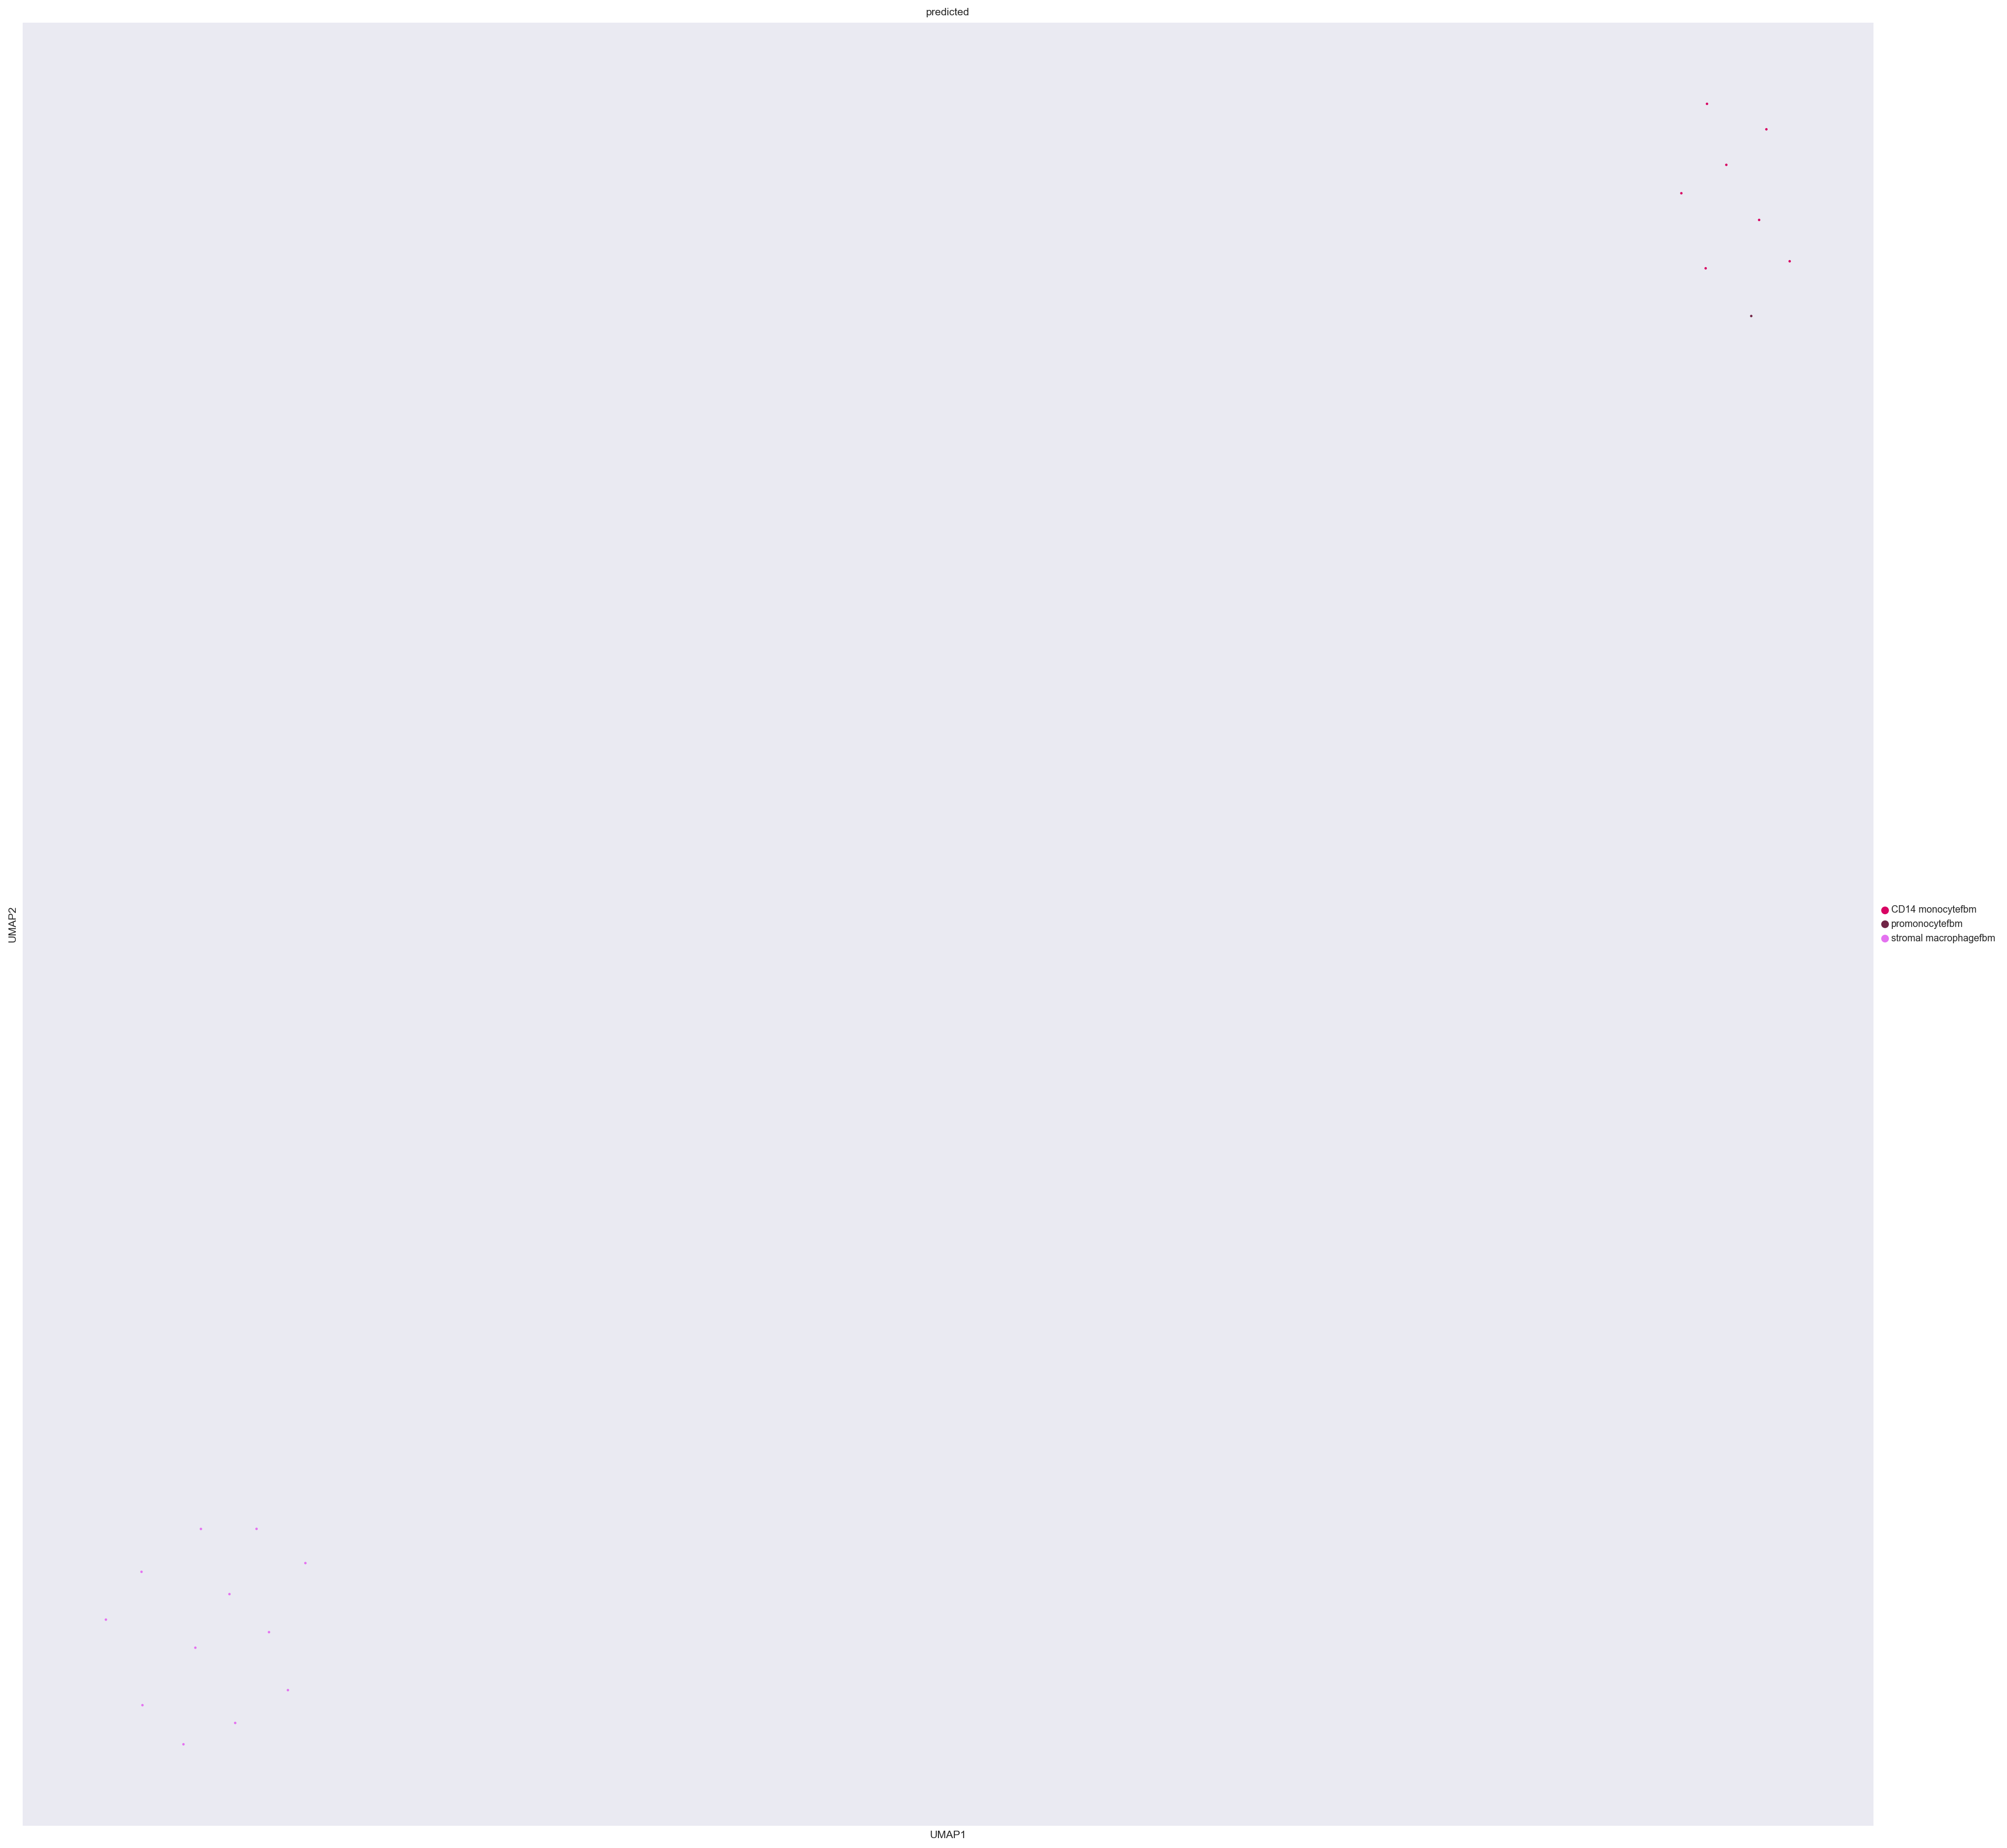

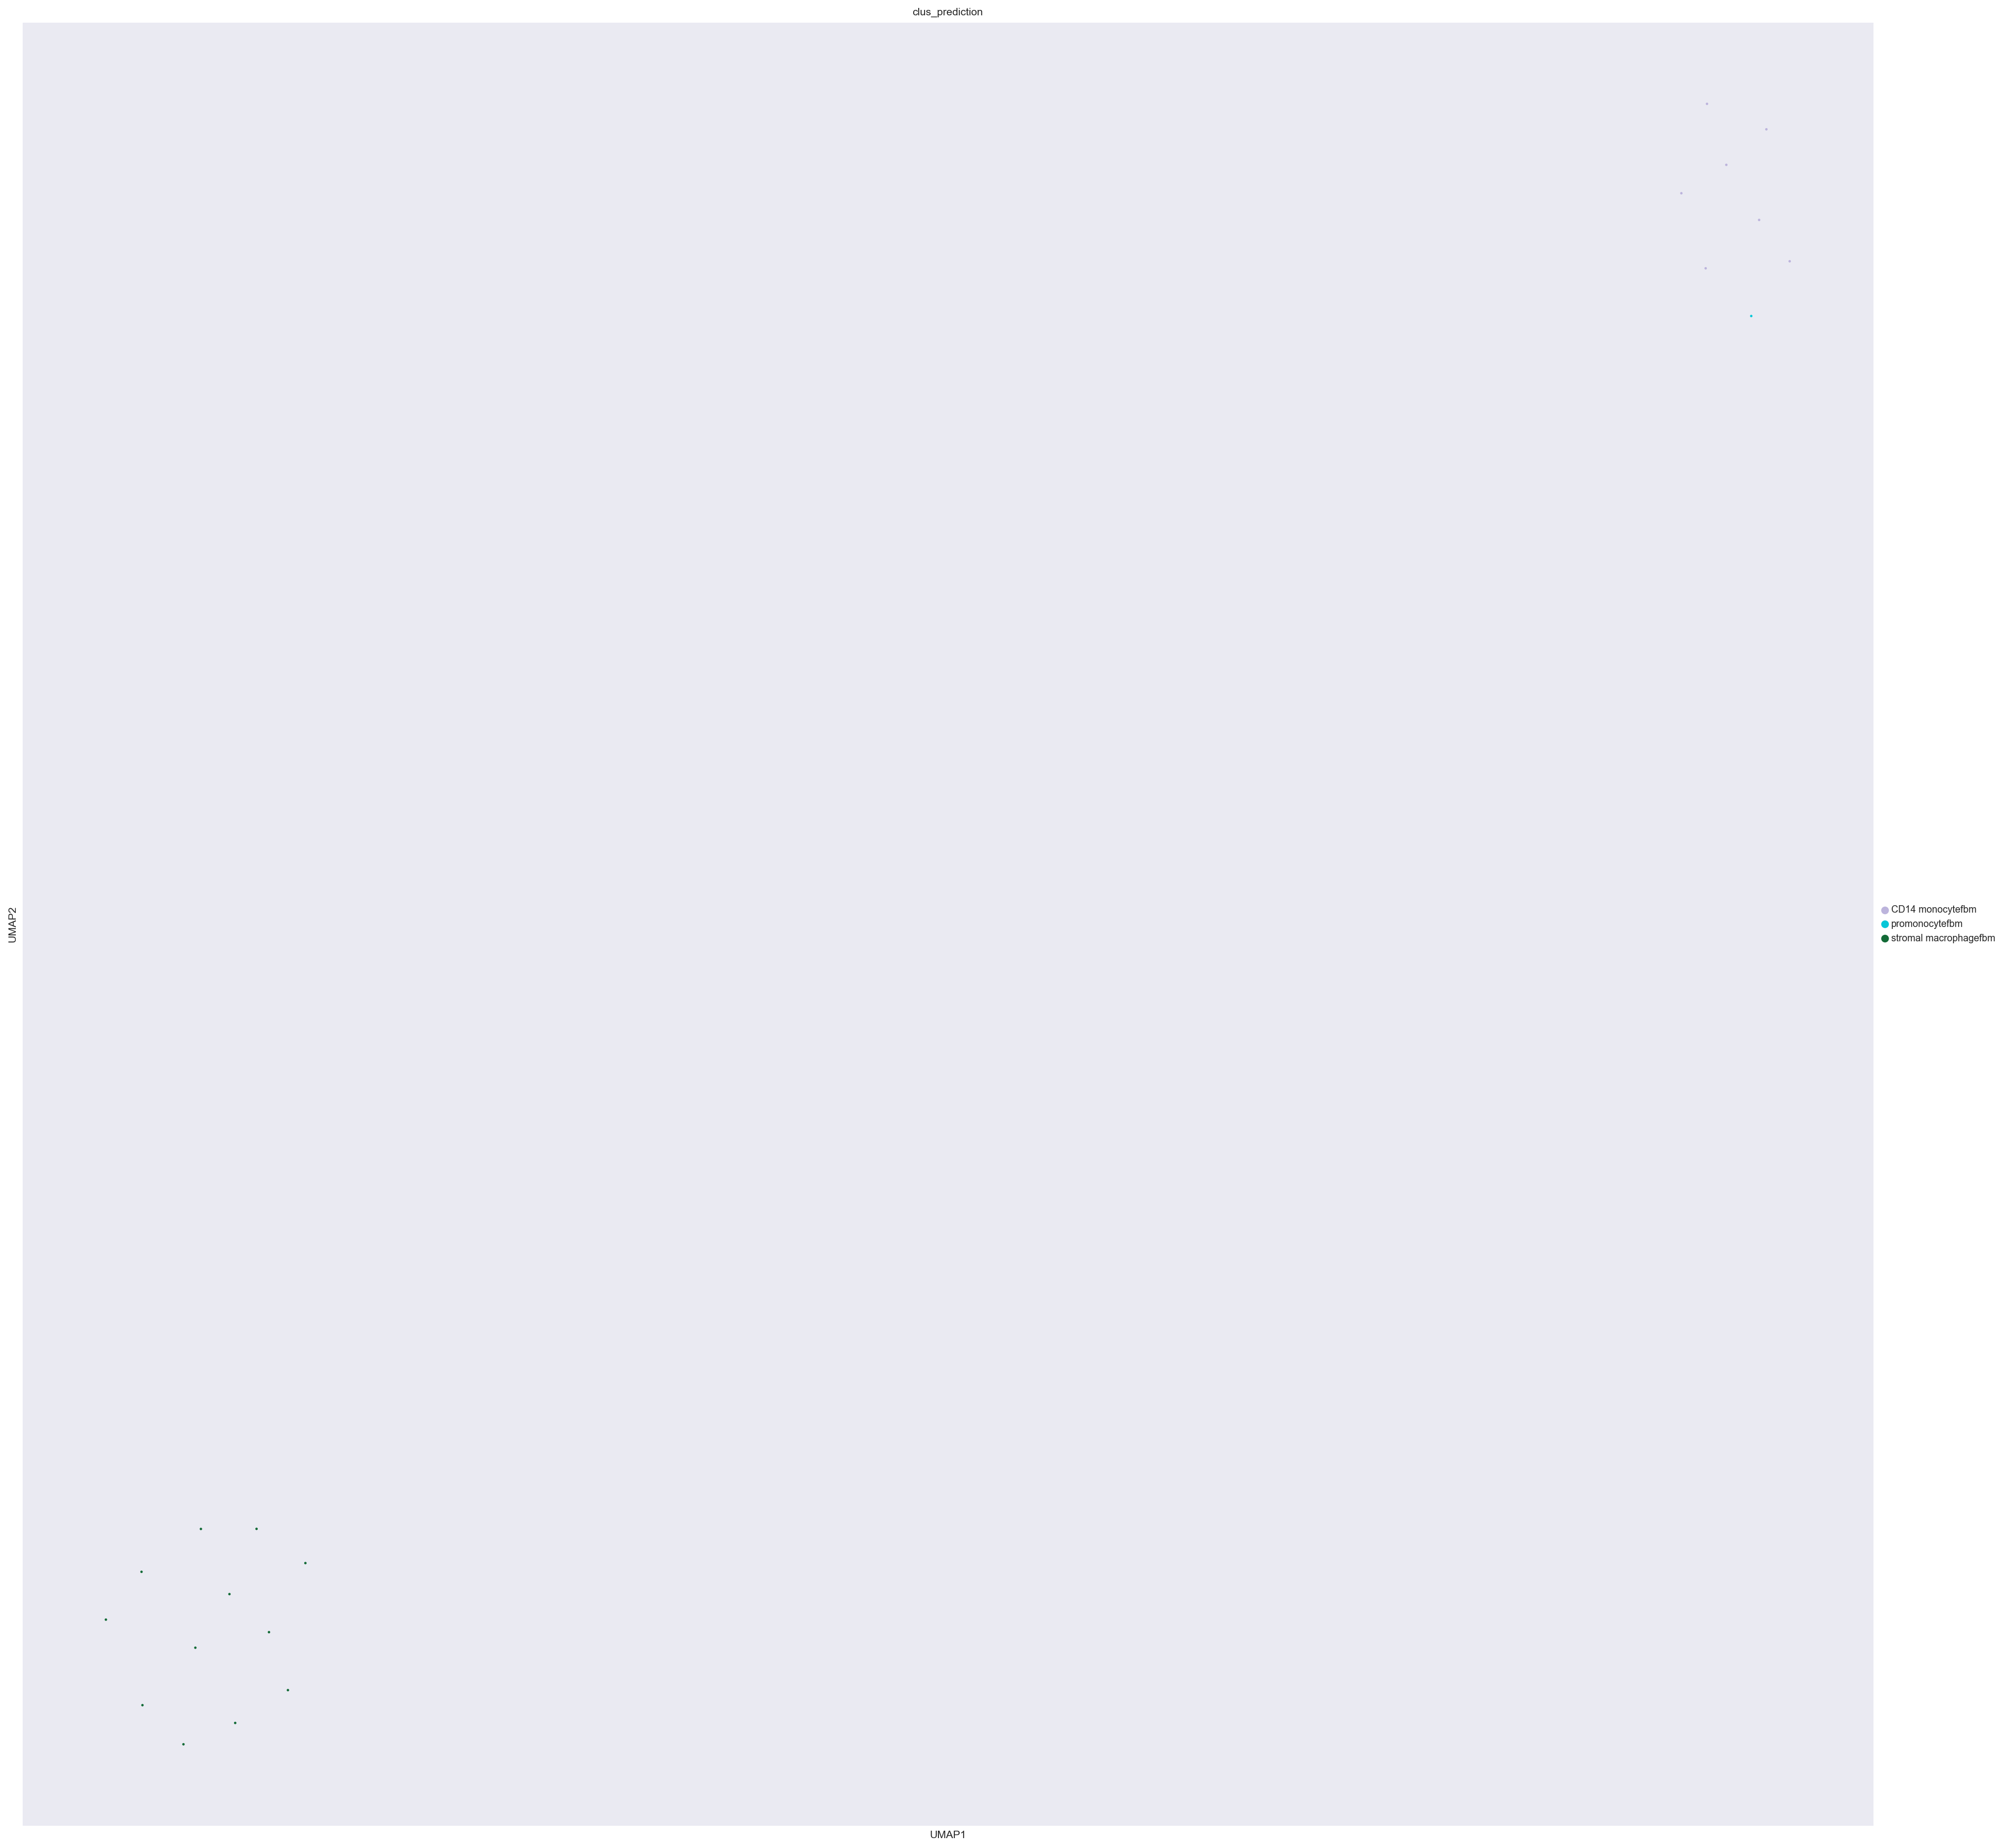

In [17]:
# Generate a umap to view your current data
sc.tl.umap(adata)

def generate_colors(col_required):
    import random
    number_of_colors = col_required
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]
    return list(color)

col = generate_colors(len(adata.obs["predicted"].unique()))
sc.pl.umap(adata, color='predicted', palette = col, save = "prediction_umap.pdf",size = 20)

col = generate_colors(len(adata.obs["clus_prediction"].unique()))
sc.pl.umap(adata, color='clus_prediction', palette = col, save = "clus_prediction_umap.pdf", size = 20)

In [18]:
# Are any celltypes removed between prediction and cluster consensus step?
prediction_set = list(adata.obs['predicted'].unique())
clust_prediction_set = list(adata.obs['clus_prediction'].unique())
non_intersect = set(prediction_set) ^ set(clust_prediction_set)
non_intersect = non_intersect.intersection(prediction_set)

if (len(non_intersect)>0):
    print(str(len(non_intersect)) + " labels were omitted during the consensus redistribution step! Please check if these labels are expected to be significantly available in the prediction dataset! Missin labels are::" )
    print("################################")
    print(non_intersect)
    
    # plot umap coloring only labels that were lost in consensus step
    sc.pl.umap(adata,color="predicted",groups=non_intersect, save = "freq_redistribution_omitted_labels_umap.pdf")
else: print("No labels were omitted!")

No labels were omitted!


In [19]:
# calculate Rand and MI
rand = sklearn.metrics.adjusted_rand_score(list(adata.obs['predicted']), list(adata.obs['clus_prediction']))
mi = sklearn.metrics.adjusted_mutual_info_score(list(adata.obs['predicted']), list(adata.obs['clus_prediction']), 
                                                average_method='arithmetic')

# test concordance between the predicted labels by cell and the consensus clusters
if ((rand<0.8) | (mi<0.8)):
    print("Your concordance between predicted and consensus leiden labels are weak, please attempt reclustering at higher resolution and running consensus again")
    print("Adj Rand extimate = " + str(rand) + "  " + "Mutual Information score=" + str(mi))
else: 
    print("success")
    print("You have achieved good consensus between predicted labels and consensus leiden labels")
    print("Adj Rand extimate = " + str(rand) + "  " + "Mutual Information score=" + str(mi))

success
You have achieved good consensus between predicted labels and consensus leiden labels
Adj Rand extimate = 1.0  Mutual Information score=1.0


In [20]:
# Note: if low could be due to removed celltypes or may be expected if the cells are quite different such as from different organs, 
# plot cells to check groups and see if group together nicely or all over 

# Save dataframe with new labels 

In [21]:
df = adata.obs[["predicted", "leiden", "clus_prediction"]]
df = df.rename(columns={"predicted": "pre_freq_clus_prediction", "clus_prediction": "post_freq_clus_prediction"})
df.to_csv(save_path + "/final_lr_metadata_for_adata2.csv")
df

,pre_freq_clus_prediction,leiden,post_freq_clus_prediction
CCR1_R1_exp_2,CD14 monocytefbm,1,CD14 monocytefbm
CCR1_R2_exp_2,promonocytefbm,2,promonocytefbm
CCR1_R3_exp_2,CD14 monocytefbm,3,CD14 monocytefbm
CCR1_R4_exp_2,CD14 monocytefbm,4,CD14 monocytefbm
CCR2_R1_exp_2,CD14 monocytefbm,5,CD14 monocytefbm
CCR2_R2_exp_2,CD14 monocytefbm,6,CD14 monocytefbm
CCR2_R3_exp_2,CD14 monocytefbm,7,CD14 monocytefbm
CCR2_R4_exp_2,CD14 monocytefbm,8,CD14 monocytefbm
CCR1_R1_exp_1,stromal macrophagefbm,9,stromal macrophagefbm
CCR1_R2_exp_1,stromal macrophagefbm,10,stromal macrophagefbm


In [22]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
plt.rcParams["figure.figsize"] = (30,30)

In [23]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


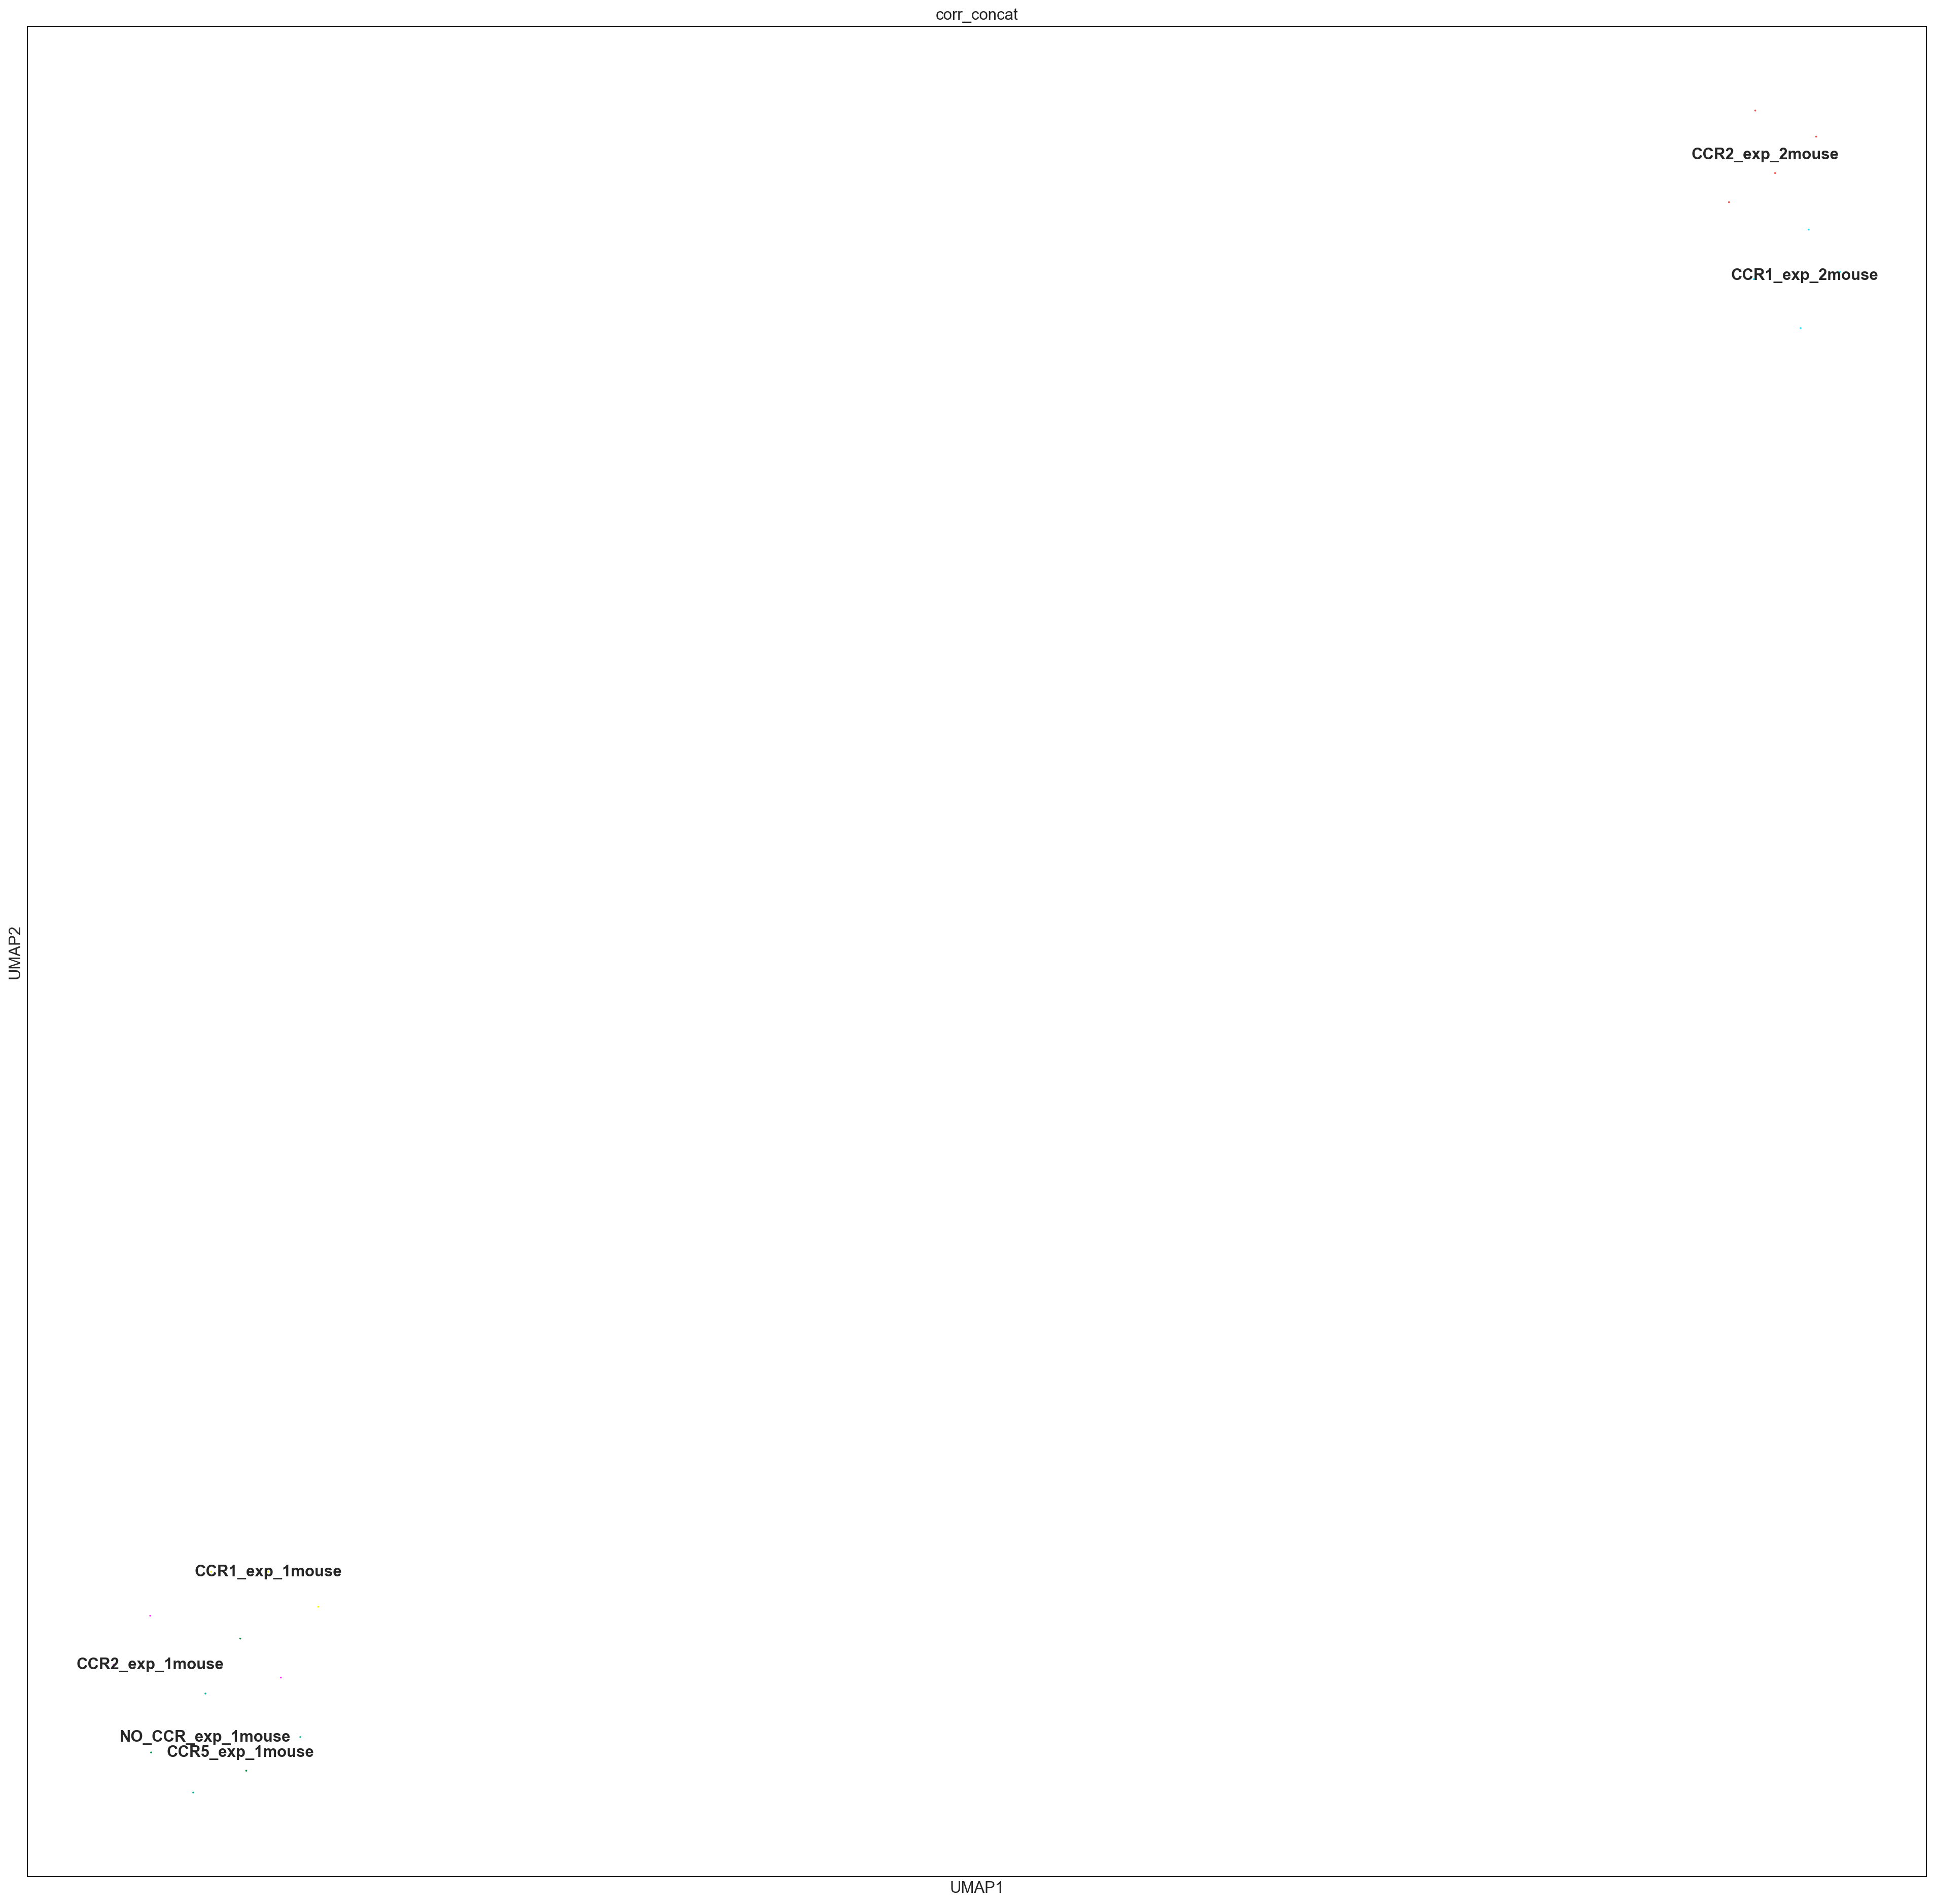

In [24]:
sc.pl.umap(adata,color=common_cat,size=10, legend_loc='on data')

In [25]:
adata.obs


,experiment_id,celltype,id,batch_id,lr_batch,batch,species_batch,corr_concat,cell.labels,fetal.ids,...,leiden_0.25,leiden_0.5,leiden_0.75,leiden_1,leiden_1.25,leiden_1.5,n_counts,predicted,clus_prediction,annot_clus_prediction_concat
CCR1_R1_exp_2,exp_2,mono,CCR1_R1_mono,CCR1_exp_2,CCR1_exp_2,0,mouseCCR1_exp_2,CCR1_exp_2mouse,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,19948092.0,CD14 monocytefbm,CD14 monocytefbm,nan_CD14 monocytefbm
CCR1_R2_exp_2,exp_2,mono,CCR1_R2_mono,CCR1_exp_2,CCR1_exp_2,0,mouseCCR1_exp_2,CCR1_exp_2mouse,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,19479070.0,promonocytefbm,promonocytefbm,nan_promonocytefbm
CCR1_R3_exp_2,exp_2,mono,CCR1_R3_mono,CCR1_exp_2,CCR1_exp_2,0,mouseCCR1_exp_2,CCR1_exp_2mouse,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,21352090.0,CD14 monocytefbm,CD14 monocytefbm,nan_CD14 monocytefbm
CCR1_R4_exp_2,exp_2,mono,CCR1_R4_mono,CCR1_exp_2,CCR1_exp_2,0,mouseCCR1_exp_2,CCR1_exp_2mouse,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,21328492.0,CD14 monocytefbm,CD14 monocytefbm,nan_CD14 monocytefbm
CCR2_R1_exp_2,exp_2,mono,CCR2_R1_mono,CCR2_exp_2,CCR2_exp_2,0,mouseCCR2_exp_2,CCR2_exp_2mouse,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,21246062.0,CD14 monocytefbm,CD14 monocytefbm,nan_CD14 monocytefbm
CCR2_R2_exp_2,exp_2,mono,CCR2_R2_mono,CCR2_exp_2,CCR2_exp_2,0,mouseCCR2_exp_2,CCR2_exp_2mouse,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,20480468.0,CD14 monocytefbm,CD14 monocytefbm,nan_CD14 monocytefbm
CCR2_R3_exp_2,exp_2,mono,CCR2_R3_mono,CCR2_exp_2,CCR2_exp_2,0,mouseCCR2_exp_2,CCR2_exp_2mouse,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,21835938.0,CD14 monocytefbm,CD14 monocytefbm,nan_CD14 monocytefbm
CCR2_R4_exp_2,exp_2,mono,CCR2_R4_mono,CCR2_exp_2,CCR2_exp_2,0,mouseCCR2_exp_2,CCR2_exp_2mouse,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,22340724.0,CD14 monocytefbm,CD14 monocytefbm,nan_CD14 monocytefbm
CCR1_R1_exp_1,exp_1,macropahge,CCR1_R1_macropahge,CCR1_exp_1,CCR1_exp_1,0,mouseCCR1_exp_1,CCR1_exp_1mouse,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10877685.0,stromal macrophagefbm,stromal macrophagefbm,nan_stromal macrophagefbm
CCR1_R2_exp_1,exp_1,macropahge,CCR1_R2_macropahge,CCR1_exp_1,CCR1_exp_1,0,mouseCCR1_exp_1,CCR1_exp_1mouse,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9914342.0,stromal macrophagefbm,stromal macrophagefbm,nan_stromal macrophagefbm
